# I) ***Importation des modules et de la base brute***

In [2]:
# Load libraries
import os
import pandas as pd
import numpy as np 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold,  GridSearchCV 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import  DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

os.chdir('D:\\SORBONNE\\M1\\S2\\ProjetPy\\AirbnbPropre')

df = pd.read_csv('VilleFinale1.csv', sep=';')

# II) ***Traitement des données***

In [2]:
# Création de la varible villes codé
for i in range(len(df["ville"])):
    if df["ville"][i]=="Paris":
        df.at[i,"villes"]=4
    if df["ville"][i]=="Lyon":
        df.at[i,"villes"]=3
    if df["ville"][i]=="Nice":
        df.at[i,"villes"]=2
    if df["ville"][i]=="Toulouse":
        df.at[i,"villes"]=1  

In [3]:
#Création de la variable score
base = df.iloc[:,3:]
base["confort"] = base["wifi"]+base["tv"]+base["clim"] 
base["secu"] = base["detect_fumee"]+base["detect_mono"]+base["kit_secours"]+base["exctincteur"]
base["secondaire"] = base["sèche_cheveux"]+base["cintres"]+base["shampooing"] 
vardel =["wifi","tv","clim","detect_fumee","detect_mono","kit_secours","exctincteur","sèche_cheveux","cintres","shampooing"]
for i in vardel:
    del base[i]
base.shape

(1843, 17)

In [4]:
base.isna().sum()

prix                           0
note                         306
Frais de service            1063
Frais de ménage             1488
Taxes de séjour et frais    1098
nbvoyageur                    57
nbchambre                    413
nblit                         20
nbsalb                        52
log_chpv                       0
log_hotel                      0
log_ent                        0
log_partagé                    0
villes                         0
confort                        0
secu                           0
secondaire                     0
dtype: int64

In [5]:
# Création de la variable Total frais
fraisbase = base[["Frais de service","Frais de ménage","Taxes de séjour et frais"]]


fraisbase.fillna(0, inplace=True)
base["Frais de service"]=fraisbase["Frais de service"]
base["Frais de ménage"]=fraisbase["Frais de ménage"]
base["Taxes de séjour et frais"]=fraisbase["Taxes de séjour et frais"]


base["Total frais"]= base["Frais de ménage"]+base["Frais de service"]+base["Taxes de séjour et frais"]
base.isna().sum()

C:\Users\gasto\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


prix                          0
note                        306
Frais de service              0
Frais de ménage               0
Taxes de séjour et frais      0
nbvoyageur                   57
nbchambre                   413
nblit                        20
nbsalb                       52
log_chpv                      0
log_hotel                     0
log_ent                       0
log_partagé                   0
villes                        0
confort                       0
secu                          0
secondaire                    0
Total frais                   0
dtype: int64

In [6]:
# imputation des valeurs manquantes de
base["nblit"] = base.groupby(['log_hotel', 'log_chpv','log_partagé'])['nblit'].apply(lambda x : x.fillna(round(x.mean())))
base["nbvoyageur"] = base.groupby(['log_hotel', 'log_chpv','log_partagé'])['nbvoyageur'].apply(lambda x : x.fillna(round(x.mean())))
base["nbchambre"] = base.groupby(['log_hotel', 'log_chpv','log_partagé'])['nbchambre'].apply(lambda x : x.fillna(round(x.mean())))
base.isna().sum()

prix                          0
note                        306
Frais de service              0
Frais de ménage               0
Taxes de séjour et frais      0
nbvoyageur                    0
nbchambre                     0
nblit                         0
nbsalb                       52
log_chpv                      0
log_hotel                     0
log_ent                       0
log_partagé                   0
villes                        0
confort                       0
secu                          0
secondaire                    0
Total frais                   0
dtype: int64

In [7]:
base["nbsalb"] = base.groupby(['nbchambre','log_hotel','log_partagé',"log_chpv"])['nbsalb'].apply(lambda x : x.fillna(round(x.mean())))
base.isna().sum()

prix                          0
note                        306
Frais de service              0
Frais de ménage               0
Taxes de séjour et frais      0
nbvoyageur                    0
nbchambre                     0
nblit                         0
nbsalb                        0
log_chpv                      0
log_hotel                     0
log_ent                       0
log_partagé                   0
villes                        0
confort                       0
secu                          0
secondaire                    0
Total frais                   0
dtype: int64

In [8]:
base["note"] = base.groupby(['confort','secu','log_partagé',"secondaire"])['note'].apply(lambda x : x.fillna(round(x.mean())))
base.isna().sum()

prix                        0
note                        0
Frais de service            0
Frais de ménage             0
Taxes de séjour et frais    0
nbvoyageur                  0
nbchambre                   0
nblit                       0
nbsalb                      0
log_chpv                    0
log_hotel                   0
log_ent                     0
log_partagé                 0
villes                      0
confort                     0
secu                        0
secondaire                  0
Total frais                 0
dtype: int64

In [9]:
# Enregistrement des variables explicatives et de la variable cible
Xbrute = base.iloc[:,1:]
Y = pd.DataFrame(base.iloc[:,0])

# III) ***Selection des variables***

## 1) **Methode de filtrage**

### Corrélation entre la variable cible et les variables explicatives

In [10]:
#Matrice de correction 

corr_matrix = base.corr()
corr_matrix

,prix,note,Frais de service,Frais de ménage,Taxes de séjour et frais,nbvoyageur,nbchambre,nblit,nbsalb,log_chpv,log_hotel,log_ent,log_partagé,villes,confort,secu,secondaire,Total frais
prix,1.000000,0.061303,0.289422,0.150789,0.134394,0.452759,0.104700,0.144839,0.007155,-0.184921,0.062605,0.348694,-0.114850,0.161674,0.031391,0.106217,0.102148,0.217144
note,0.061303,1.000000,0.071236,-0.020673,0.047607,-0.038634,-0.010465,-0.042808,-0.025329,0.030663,-0.022287,-0.106645,-0.140824,-0.032090,0.013547,-0.005632,0.044881,0.015624
Frais de service,0.289422,0.071236,1.000000,0.667151,0.787441,0.117932,-0.011277,0.033078,-0.024157,-0.225528,-0.114990,0.208384,-0.072064,0.034962,-0.000773,-0.042953,0.048713,0.867975
Frais de ménage,0.150789,-0.020673,0.667151,1.000000,0.478585,0.186341,0.006942,0.064806,-0.012334,-0.128759,-0.065650,0.212970,-0.041143,0.003938,0.010466,-0.034280,0.063442,0.947944
Taxes de séjour et frais,0.134394,0.047607,0.787441,0.478585,1.000000,0.031678,-0.031730,-0.006955,-0.035779,-0.249102,-0.127010,0.144912,-0.079597,0.040790,0.004443,-0.040059,0.022483,0.675439
nbvoyageur,0.452759,-0.038634,0.117932,0.186341,0.031678,1.000000,0.446807,0.629166,0.394062,-0.149851,0.022028,0.248978,-0.046516,-0.022107,0.048939,0.104155,0.107868,0.170736
nbchambre,0.104700,-0.010465,-0.011277,0.006942,-0.031730,0.446807,1.000000,0.742283,0.917423,-0.036864,0.208945,-0.014947,-0.012301,0.039677,0.020573,0.104602,0.029052,-0.001498
nblit,0.144839,-0.042808,0.033078,0.064806,-0.006955,0.629166,0.742283,1.000000,0.767601,-0.064762,0.134795,0.015179,0.062562,0.003510,0.037420,0.105107,0.052953,0.055319
nbsalb,0.007155,-0.025329,-0.024157,-0.012334,-0.035779,0.394062,0.917423,0.767601,1.000000,-0.014078,0.233121,-0.043415,-0.005096,0.049514,0.012060,0.089264,0.023335,-0.019461
log_chpv,-0.184921,0.030663,-0.225528,-0.128759,-0.249102,-0.149851,-0.036864,-0.064762,-0.014078,1.000000,-0.060330,-0.327043,-0.037809,0.005258,0.011181,-0.044390,-0.062787,-0.185596


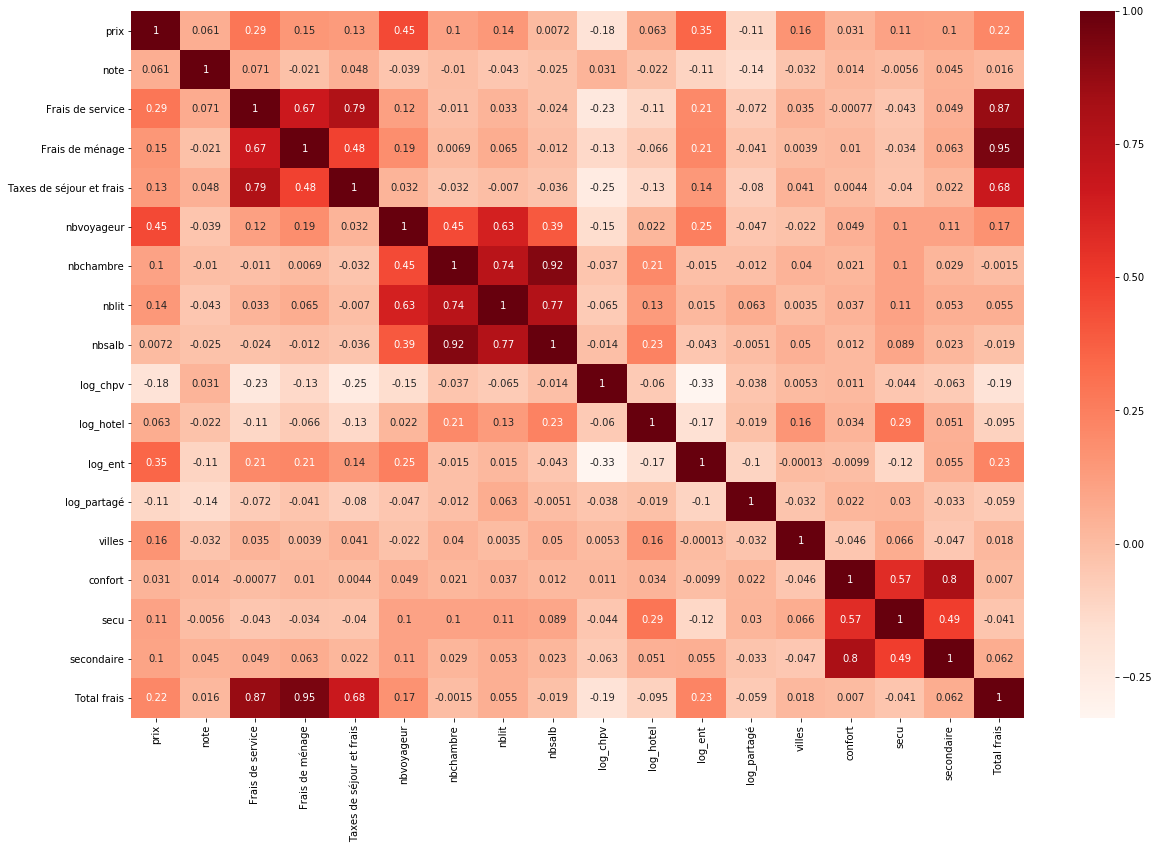

In [11]:
#Utilisation de la correlation de Pearson 
plt.figure (figsize = (20,13)) 
cor = base.corr () 
sns.heatmap (cor, annot = True, cmap = plt.cm.Reds) 
plt.show ()

In [12]:
#Sélection de caractéristiques hautement corrélées 
cor_target = abs (cor ["prix"])
relevant_features = cor_target [cor_target> 0.1] 
relevant_features

prix                        1.000000
Frais de service            0.289422
Frais de ménage             0.150789
Taxes de séjour et frais    0.134394
nbvoyageur                  0.452759
nbchambre                   0.104700
nblit                       0.144839
log_chpv                    0.184921
log_ent                     0.348694
log_partagé                 0.114850
villes                      0.161674
secu                        0.106217
secondaire                  0.102148
Total frais                 0.217144
Name: prix, dtype: float64

In [13]:
#Les variables linéairements pertinantes
LesCorrLin = relevant_features.index.tolist()
basecol = base.columns.tolist()
for x in LesCorrLin :
    basecol.remove(x)
CorrNonLin = basecol
CorrNonLin

['note', 'nbsalb', 'log_hotel', 'confort']

### Corrélation non linéaire 

In [14]:
ListNonLin=[]
for i in CorrNonLin:
    ListNonLin.append(scipy.stats.kendalltau(base["prix"],base[i]) )
ListNonLin

[KendalltauResult(correlation=0.02151818999540704, pvalue=0.19795039094669276),
 KendalltauResult(correlation=0.06790799039381155, pvalue=0.000383390539267254),
 KendalltauResult(correlation=0.06564926172311071, pvalue=0.0006442615431328331),
 KendalltauResult(correlation=0.01843255225173405, pvalue=0.33802661890175156)]

In [15]:
FilterCorr = LesCorrLin + ['note', 'nbsalb']
FilterCorr

['prix',
 'Frais de service',
 'Frais de ménage',
 'Taxes de séjour et frais',
 'nbvoyageur',
 'nbchambre',
 'nblit',
 'log_chpv',
 'log_ent',
 'log_partagé',
 'villes',
 'secu',
 'secondaire',
 'Total frais',
 'note',
 'nbsalb']

### Corrélation entre les variables explicatives

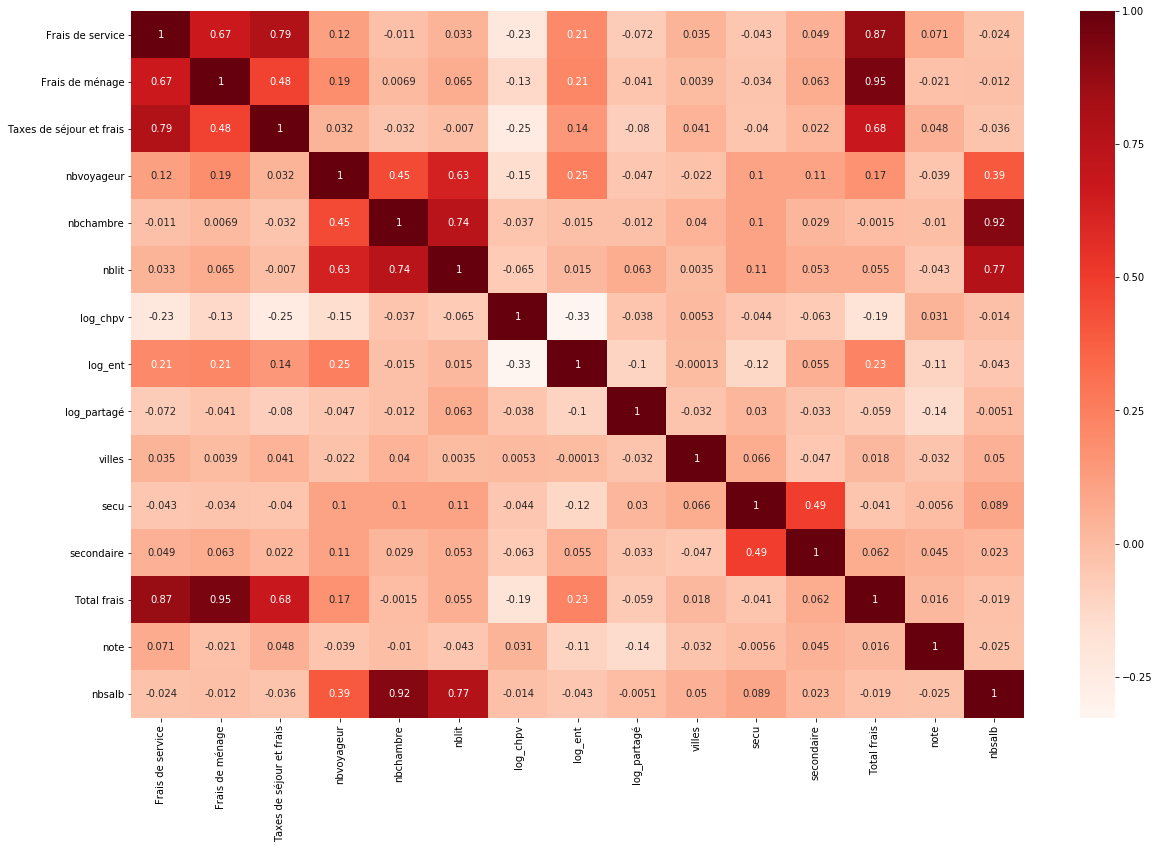

In [16]:

InterCorr =  FilterCorr[1:]
baseSec = base[InterCorr]
plt.figure (figsize = (20,13)) 
cor = baseSec.corr () 
sns.heatmap (cor, annot = True, cmap = plt.cm.Reds) 
plt.show ()

In [17]:
corr_features = cor[abs (cor)> 0.6] 
corr_features = corr_features.where(~(corr_features==1))
corr_features

,Frais de service,Frais de ménage,Taxes de séjour et frais,nbvoyageur,nbchambre,nblit,log_chpv,log_ent,log_partagé,villes,secu,secondaire,Total frais,note,nbsalb
Frais de service,NaN,0.667151,0.787441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.867975,NaN,NaN
Frais de ménage,0.667151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.947944,NaN,NaN
Taxes de séjour et frais,0.787441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.675439,NaN,NaN
nbvoyageur,NaN,NaN,NaN,NaN,NaN,0.629166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nbchambre,NaN,NaN,NaN,NaN,NaN,0.742283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.917423
nblit,NaN,NaN,NaN,0.629166,0.742283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.767601
log_chpv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_ent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_partagé,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
villes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Enregistrer la base issue du filtrage
AutoCorr = ["prix","Frais de service","Frais de ménage","Taxes de séjour et frais","nblit","nbsalb"]
for x in AutoCorr:
    FilterCorr.remove(x)
FilterCorr
Xcorr = base[FilterCorr]

## 2) **Méthode Recursive Feature Elimination (RFE)**

In [19]:
# Enregistrement des modeles
X= Xbrute
models = [("RF",RandomForestRegressor(random_state=0)),("GBR", GradientBoostingRegressor(random_state=0)),("DTR",DecisionTreeRegressor(random_state=0))]
#nombre des variables  
nof_list = np.arange (1,19)             

#Nombre de variables optimales        
NbVar = []
for nomodel, modele in models:
    nof = 0 
    high_score = 0 
    for n in range (len (nof_list)): 
        X_train, X_test, y_train, y_test = train_test_split (X, Y, test_size = 0.2, random_state = 0) 
        model = modele
        rfe = RFE (model, nof_list [n]) 
        X_train_rfe = rfe.fit_transform (X_train, y_train) 
        X_test_rfe = rfe.transform(X_test)
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train_rfe, y_train, cv=10)
        score = cv_results.mean()
        if (score> high_score): 
            high_score = score 
            nof = nof_list [n]
    NbVar.append((nof,nomodel,modele))


C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages

In [20]:
# Enregistrement des bases RFE selon le modele
X = Xbrute
Xrfe=[]
RfeVars=[]
cols = list (X.columns)
for nb,nomodel, modele in NbVar:
    rfe = RFE (modele, nb)             
    #Transformation de données à l'aide de RFE 
    X_rfe = rfe.fit_transform (X, Y)  
    #Ajustement des données au modèle 
    model.fit (X_rfe, Y)               
    temp = pd.Series (rfe.support_, index = cols) 
    selected_features_rfe = temp [temp == True] .index 
    RfeVar = selected_features_rfe.tolist()
    Xrfe.append((nomodel,base[RfeVar]))
    RfeVars += RfeVar

C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages

## 3) **Méthode intégrée**

In [22]:
X=Xbrute
reg = LassoCV()
reg.fit(X, Y)
print("Meilleur alpha using built-in LassoCV: %f" % reg.alpha_)
print("Meilleur score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)

Meilleur alpha using built-in LassoCV: 1.889091
Meilleur score using built-in LassoCV: 0.351180


C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, "Importance des variables à l'aide du modèle Lasso")

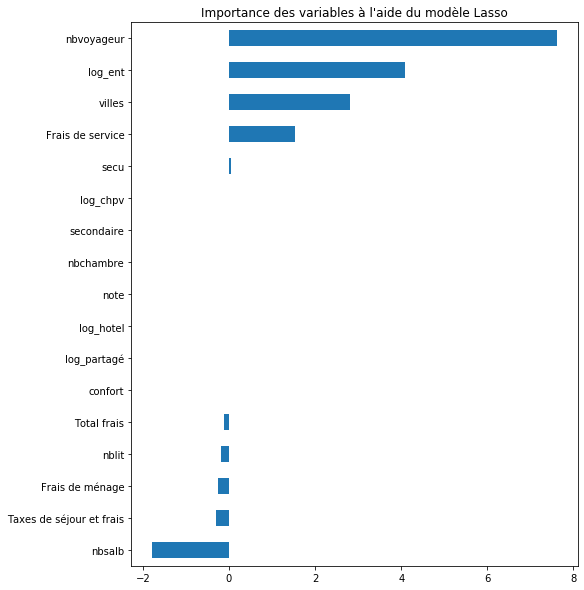

In [23]:
imp_coef = coef.sort_values() 
import matplotlib 
matplotlib.rcParams ['figure.figsize'] = (8.0, 10.0) 
imp_coef.plot (kind = "barh") 
plt.title ("Importance des variables à l'aide du modèle Lasso")

In [24]:
#Enregistrement de la base
LossVar = imp_coef.index.where(imp_coef!=0)
LossVar = pd.DataFrame(LossVar)
LossVar = LossVar[~(LossVar==np.nan)].iloc[:,0].unique().tolist()
del LossVar[5]
LossVar
Xloss = base[LossVar]

## 4) **Détermination des meilleures variables**
### selon l'intersection des bases

In [25]:
# Les meilleures variables

BestVar = set(LossVar)&set(RfeVars)&set(FilterCorr)
BestVar = list(BestVar)
Xbest=base[BestVar]
BestVar

['log_ent', 'nbvoyageur', 'Total frais', 'villes', 'secu']

# IV) ***Lancement des modèles***

In [26]:
# Agreation des toutes les bases
Xtot= [("Brute",Xbrute),("VarCorr",Xcorr),("VarLoss",Xloss),("VarBest",Xbest)]

# Ajout des bases RFE
index=[]
for nomodel, data in Xrfe:
    Xtot.append(("VaRfe"+nomodel,data))
    index.append(nomodel)

colonne=[]
for col,i in Xtot:
    colonne.append(col)

#Lancement des modeles
results = []
noms = []
TabSorti = pd.DataFrame(index = index, columns = colonne)
ScoreBest =0
for nomdata, X in Xtot:
    #Mettre à l'echelle les données
    X_train, X_test, Y_train, Y_test = train_test_split(X , Y, test_size=0.20, random_state=1)
    scaler = StandardScaler()
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    for nomodel, modele in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(modele, X_train, Y_train, cv=10)
        scor = cv_results.mean()
        TabSorti.at[nomodel, nomdata]= scor
        #Enregistrment du couple meilleur modele et base
        if scor>  ScoreBest :
            BestModel = nomodel
            mod = modele
            BestData = nomdata
            ScoreBest = scor
            Sqrt =cv_results.std()
            bX_train, bX_test, bY_train, bY_test = X_train, X_test, Y_train, Y_test
            
            

print("Meilleur model : ",BestModel,"\n","Meilleure modelisation :",BestData)
print("Sa moyenne : ", ScoreBest, "\n","Son Ecart-type",Sqrt)
print("Table de sortie")
TabSorti

C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  esti

Meilleur model :  GBR 
 Meilleure modelisation : Brute
Sa moyenne :  0.5996780236451726 
 Son Ecart-type 0.12649245925753022
Table de sortie


,Brute,VarCorr,VarLoss,VarBest,VaRfeRF,VaRfeGBR,VaRfeDTR
RF,0.514194,0.303647,0.5129,0.284701,0.502711,0.514194,0.540883
GBR,0.599678,0.458874,0.559881,0.379071,0.595195,0.599678,0.562136
DTR,0.27659,-0.0666895,0.339771,0.0689276,0.259334,0.27659,0.522806


In [27]:
# Evaluation du selectionné
mod.fit(bX_train, bY_train)
y_pred=mod.predict(bX_test) 
print("Importances des variables")
print (mod.feature_importances_ )
print("\n","R2 lors de l'entrainement")
print(mod.score(bX_train, bY_train))
print("\n","R2 lors du test")
print(mod.score(bX_test, bY_test))

Importances des variables
[0.03254346 0.30448438 0.03731574 0.01926    0.28967405 0.09539653
 0.00379182 0.04095613 0.01088074 0.00702117 0.05719423 0.00664516
 0.06101492 0.00081152 0.00935801 0.00479211 0.01886001]

 R2 lors de l'entrainement
0.7383933551850086

 R2 lors du test
0.532588796321158


C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# V) ***Amélioration du modele***

In [251]:
# Amélioration du modele selectionné
param_grid={"loss" : ["ls", "lad", "huber", 'quantile'],'n_estimators':[100,200,500], 'learning_rate': [0.1,0.05,0.02],
             'max_depth':[3,4,5,10], 'min_samples_leaf':[2,3,5], 'max_features':[1.0],
            "min_impurity_decrease": [0.0, 0.5, 1.0, 0.5]} 
n_jobs = 4
def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor() 
    classifier = GridSearchCV(estimator=estimator, cv=5, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(bX_train, bY_train)
    print (classifier.best_estimator_) 
    return classifier.best_estimator_ 
best_est=GradientBooster(param_grid, n_jobs)

C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=5,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.5, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


NameError: name 'cv' is not defined

In [28]:
best_est = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=5,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.5, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
# Evaluation du model amélioré
best_est.fit(bX_train, bY_train)
y_pred=best_est.predict(bX_test) 
print("Importances des variables")
print (best_est.feature_importances_ )
print("\n","R2 lors de l'entrainement")
print(best_est.score(bX_train, bY_train))
print("\n","R2 lors du test")
print(best_est.score(bX_test, bY_test))

C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Importances des variables
[3.80321957e-02 3.36237114e-01 5.14275157e-02 1.81241919e-02
 1.50376052e-01 2.33543618e-02 1.89080401e-02 1.24198815e-02
 1.70914082e-02 1.18995567e-02 1.81800492e-01 1.14502459e-02
 7.57195166e-02 2.32499918e-04 2.52537383e-02 3.47056902e-03
 2.42026203e-02]

 R2 lors de l'entrainement
0.8036021671100863

 R2 lors du test
0.6756336455475211


In [30]:
Xbrute.head()

,note,Frais de service,Frais de ménage,Taxes de séjour et frais,nbvoyageur,nbchambre,nblit,nbsalb,log_chpv,log_hotel,log_ent,log_partagé,villes,confort,secu,secondaire,Total frais
0,4.5,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0,0.0
1,4.6,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0
2,4.6,9.0,10.0,2.0,4.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,2.0,3.0,21.0
3,4.6,0.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0
4,5.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,3.0,0.0


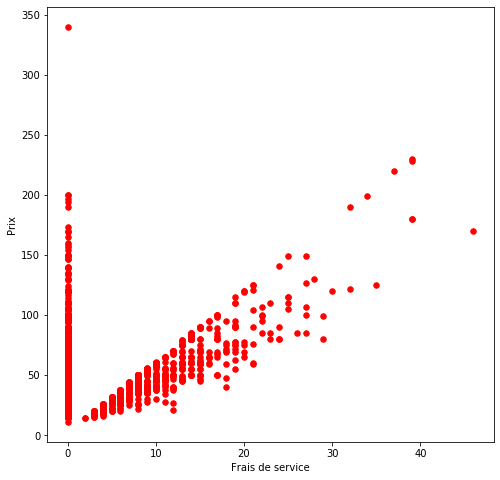

In [37]:
plt.figure (figsize = (8,8)) 
plt.scatter(Xbrute["Frais de service"],Y, c="red", s=30)
plt.xlabel("Frais de service")
plt.ylabel("Prix")
plt.show()

# Application de Machine Learning : EasyML

### L'application EasyMy permet de réaliser les différentes étapse d'un projet de Data Science : 
    Elle comporte 4 parties :  

## I) Téléchargement des données
      EasyML vous permet de télécharger vos données afin de d'en avoir un aperçu. Vous pouvez selectionner les variables à afficher ainsi que le nombre de lignes

## II) Statistiques descriptives et visualisation 
       Réalisez des statistiques descriptives sur vos variables, ainsi que la description de chacune des variables.
       EasyML détecte automatiquement le type de variables et présente les statistiques adéquates.
       Obtenez aussi visuellement le descriptif des voriables par des graphiques simpples et explicites. Ajoutez plus d'options sur chacun de vos graphiques afin de mieux                            comprendre vos données.

# III) Analyse
       Affinez vos analyses en realisant des test statistique plus poussés tels que le l'annalyse de la corrélation, l'annalyse en composante principale, la regression linéaire, la regression lasso et le test de Kchi-2.
    Celà vous permet de mieux selectionner les variables pour la réalisation des modeles de Machine Learning

## IV) Modelisation
    Exécutez divers modèles de Machine de Learning dont la RandomForest, le CatBoost et obtenez les résultats en un laps de temps. EasyML vous permet d'excuter vos modèles en cross validation.
    Vous pouurez aussi les améliorer avec un GridSearch afin d'obtenir de meilleurs résultats